# KOI

Imports

In [8]:
import graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import naive_bayes
from sklearn import tree

from sklearn import model_selection
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc
from sklearn.metrics import precision_score


Default parameters

In [2]:
k = 5
colors = ['darkorange', 'y', 'blue', 'red', 'purple']

### Import dataset

In [3]:
df = pd.read_csv('file/ds_koi_data.csv')

label_pos = 'CONFIRMED'
label_neg = 'FALSE POSITIVE'

col_id = 'kepoi_name'
col_target = 'koi_disposition'

features = list(df.columns)
features.remove(col_target)
features.remove(col_id)

X = df[features].values
y = df[col_target] == label_pos

### ROC $\times$ AUC

TODO: ADD Description...

In [37]:
def cv_and_roc(classifier, X: np.array, y: np.array, title: str, k: int, colors: list):

    fig, ax = plt.subplots(figsize=(15, 8))
    cv = model_selection.StratifiedShuffleSplit(n_splits=k)

    # Calculate cross validation average scores
    tprs = []
    aucs = []
    recalls = np.array([])
    accuracies = np.array([])
    precisions = np.array([])

    # Plot ROC's for each fold
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])

        viz = RocCurveDisplay.from_estimator(
            classifier, X[test], y[test],
            name="CV {}".format(i + 1),
            ax=ax, linestyle=":", lw=1, color=colors[i]
        )

        # Compute fold
        aucs.append(viz.roc_auc)
        recalls = np.append(recalls, viz.tpr)
        accuracies = np.append(accuracies, classifier.score(X[test], y[test]))
        precisions = np.append(precisions, precision_score(y[test], classifier.predict(X[test])))
        
        aux = np.interp(mean_fpr, viz.fpr, viz.tpr)
        aux[0] = 0.0
        tprs.append(aux)

    # Plot cross validation average score
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    ax.plot(mean_fpr, mean_tpr, color="g", lw=2, linestyle='-', label='ROC (mean)')

    if (std_auc):
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=0.3, label=r"$\pm$ std. dev.")

    # Plot 50% chance classifier reference
    ax.plot([0, 1], [0, 1], linestyle="--", lw=1, color='brown', label="Chance", alpha=0.5)

    # Show it all
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=r"%s | AUC = %0.2f $\pm$ %0.2f" % (title, mean_auc, std_auc))
    ax.legend(loc="lower right")
    plt.show()

    # Return scores
    return accuracies, precisions, recalls

## Naive Bayes

TODO: ADD Description...

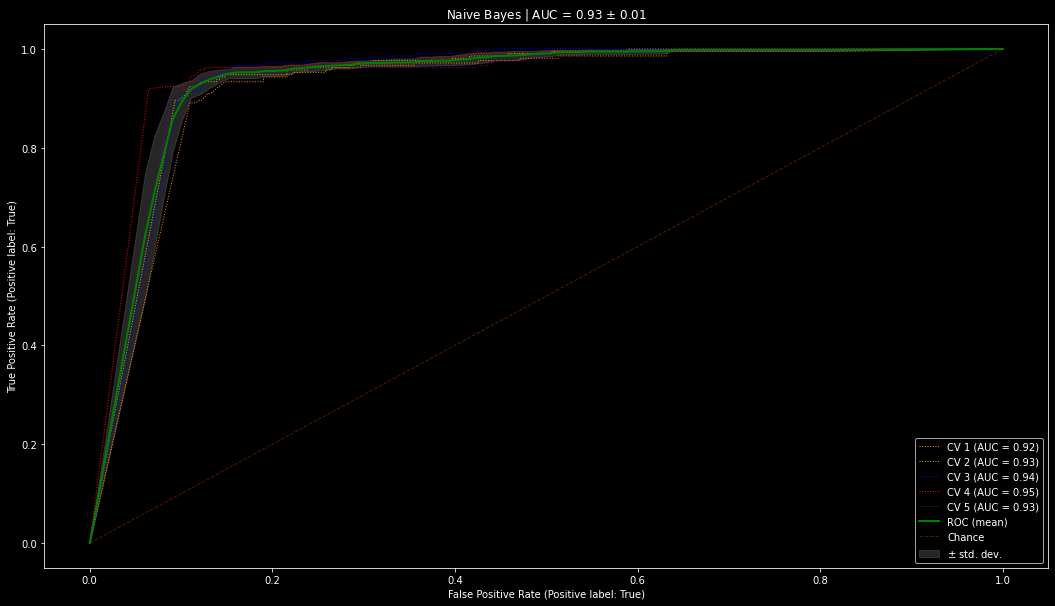

In [14]:

cv_and_roc(classifier=naive_bayes.GaussianNB(), title='Naive Bayes', X=X, y=y, k=k, colors=colors)

## Decision Tree

TODO: ADD Description...

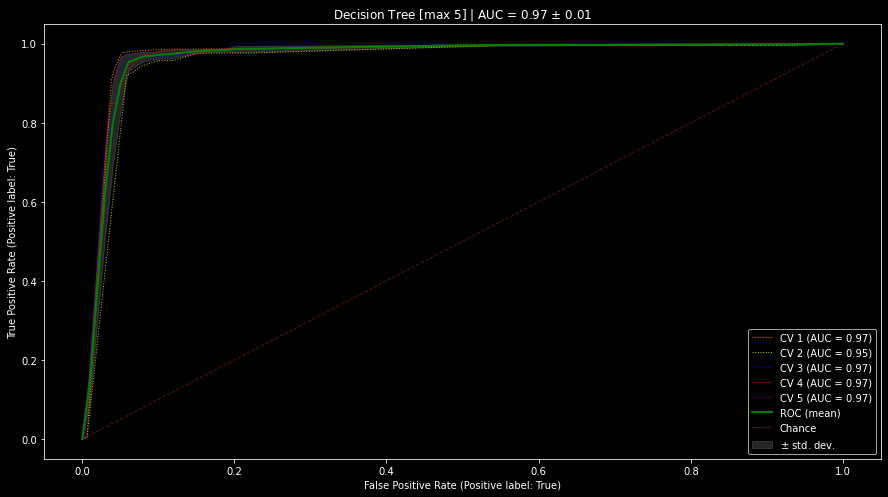

Decision Tree [max 5]: avg accuracy: 0.95, avg precision: 0.92, avg recall: 0.83


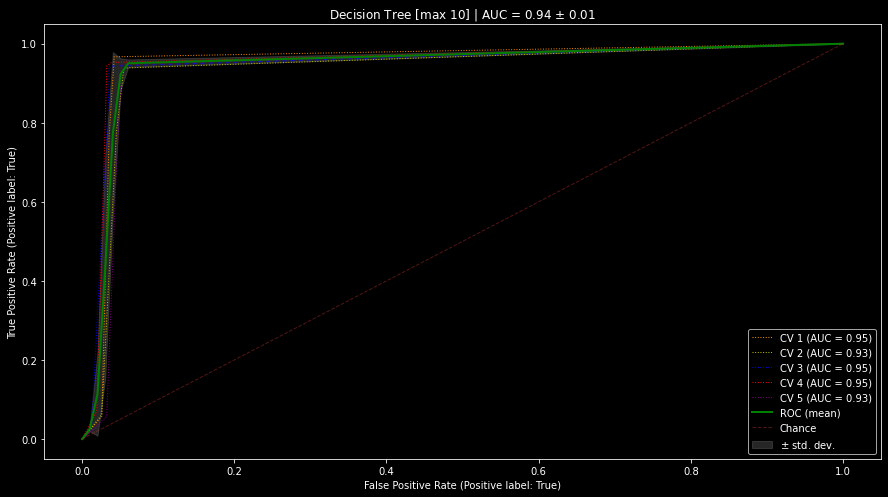

Decision Tree [max 10]: avg accuracy: 0.95, avg precision: 0.94, avg recall: 0.63


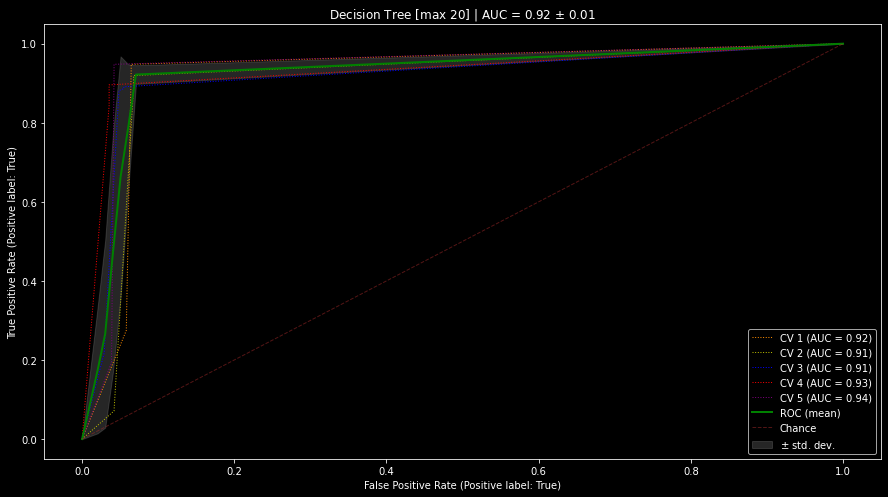

Decision Tree [max 20]: avg accuracy: 0.94, avg precision: 0.92, avg recall: 0.63


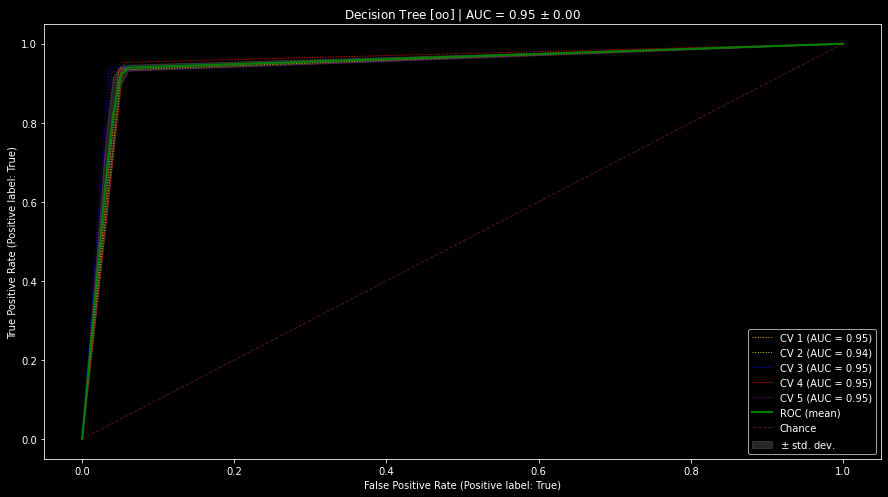

Decision Tree [oo]: avg accuracy: 0.95, avg precision: 0.93, avg recall: 0.65


In [44]:
dt_random_state = 10

for max_depth in [5, 10, 20, None]:

    # CV evaluate
    title = 'Decision Tree ' + (r"[max %d]" % (max_depth) if max_depth else '[oo]')
    classifier = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=dt_random_state)
    accuracies, precisions, recalls = cv_and_roc(classifier=classifier, title=title, X=X, y=y, k=k, colors=colors)
    
    # Build tree image
    dot_data = tree.export_graphviz(
        classifier, feature_names=features, class_names=[label_pos, label_neg],
        out_file=None, filled=True, rounded=True,
    )
    graph = graphviz.Source(source=dot_data, format='png', directory='file')

    # Save tree image
    depth_idx_str = ('0' + str(max_depth))[-2:]
    tree_img_name = 'dt-' + (depth_idx_str if max_depth else 'oo')
    graph.render(tree_img_name)

    # Show statistics
    print(r"%s: avg accuracy: %.2f, avg precision: %.2f, avg recall: %.2f" % (title, accuracies.mean(), precisions.mean(), recalls.mean()))